In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pp
%matplotlib inline
from os import listdir
from os.path import isfile, join
from functools import reduce
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [2]:
####---------------------------DATA MANIPULATION ---------------------------------####
#load the currencies files
path='data/'
CurrenciesFilesPath = ['data/'+f for f in listdir(path) if isfile(join(path, f))]
for file in CurrenciesFilesPath:
    print(file)

data/BCH-USD.csv
data/BTC-USD.csv
data/ETH-USD.csv
data/IOT-USD.csv
data/LTC-USD.csv
data/XMR-USD.csv
data/XRP-USD.csv


In [3]:
config=tf.config
config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
#now the idea is to put all these data together in a single variable, matching them with the date variable

#make a list of the data? -> a list of dataframes?
#data=[pd.read_csv(f) for f in CurrenciesFilesPath]
data=[pd.read_csv(f, index_col='Date', parse_dates=['Date'], converters={'Close':np.float32}) for f in CurrenciesFilesPath]

#Remove the useless columns
####data=[currency.drop(['Date','Open','High','Low','Adj Close','Volume'],1) for currency in data]
data=[currency.drop(['Open','High','Low','Adj Close','Volume'],1) for currency in data]

In [5]:
#Rename the colone Close to the name of the currency
temp=[f.split('/')[1].split('.')[0] for f in CurrenciesFilesPath]
for i, Table in enumerate(data):
    #Table.columns=['Date',temp[i]]
    Table.columns=[temp[i]]
    
for table in data:
    print(table.head())

                BCH-USD
Date                   
2018-01-09  2376.679932
2018-01-10  2856.929932
2018-01-11  2437.919922
2018-01-12  2596.199951
2018-01-13  2664.899902
                 BTC-USD
Date                    
2018-01-11  13308.059570
2018-01-12  13841.190430
2018-01-13  14243.120117
2018-01-14  13638.629883
2018-01-15  13631.980469
                ETH-USD
Date                   
2018-01-09  1289.239990
2018-01-10  1248.989990
2018-01-11  1139.319946
2018-01-12  1261.030029
2018-01-13  1385.020020
            IOT-USD
Date               
2018-01-09     3.53
2018-01-10     3.75
2018-01-11     3.35
2018-01-12     3.64
2018-01-13     3.90
               LTC-USD
Date                  
2018-01-09  246.039993
2018-01-10  249.100006
2018-01-11  226.529999
2018-01-12  235.350006
2018-01-13  257.940002
               XMR-USD
Date                  
2018-01-09  410.690002
2018-01-10  403.519989
2018-01-11  352.950012
2018-01-12  389.399994
2018-01-13  416.290009
            XRP-USD
Date   

In [6]:
#Join tables (index are dates for all of them)
df_final=data[0].join(data[1:])
print('Lenght of table : '+ str(len(df_final)))
df_final=df_final.dropna()
df_final

Lenght of table : 486


,BCH-USD,BTC-USD,ETH-USD,IOT-USD,LTC-USD,XMR-USD,XRP-USD
Date,,,,,,,
2018-01-11,2437.919922,13308.059570,1139.319946,3.3500,226.529999,352.950012,1.9300
2018-01-12,2596.199951,13841.190430,1261.030029,3.6400,235.350006,389.399994,2.0200
2018-01-13,2664.899902,14243.120117,1385.020020,3.9000,257.940002,416.290009,2.0000
2018-01-14,2530.209961,13638.629883,1359.479980,3.7200,236.860001,394.459991,1.8300
2018-01-15,2394.050049,13631.980469,1278.689941,3.4700,231.889999,412.820007,1.6600
...,...,...,...,...,...,...,...
2018-12-30,163.220001,3896.209961,141.330002,0.3669,32.020000,49.160000,0.3752
2018-12-31,149.229996,3747.389893,133.490005,0.3606,30.129999,46.560001,0.3564
2019-01-01,165.020004,3880.149902,142.660004,0.3753,32.119999,49.169998,0.3709


In [7]:
#---------------------------MACHINE LEARNING ---------------------------------####
#---------------------------Full series!!!---------------------------------####
#Construct the variables
    #X goes from day 0 to N-1
    #Y (to predict) goes from day 1 to N
    #Select the column from the df_final as variable to predict (Y)
df_final=df_final.fillna(method='bfill')
X=df_final.copy()
X=X.dropna(axis=0)

#x_train = x_train.reshape(60000, 784).astype('float32') / 255
#x_test = x_test.reshape(10000, 784).astype('float32') / 255

print(len(X))
#X=X.dropna(axis=0)
#print('Without nan, len of X= '+ str(len(X['BTC-USD'])))
Y=X['BTC-USD'].iloc[1:].copy()
X=X[:-1]
print('Y len = ' + str(len(Y)))
print('X len =' + str(len(X)))
Y.tail()

#Remove 15% percent of the data to test later on, but on cronological order.
number_to_cutoff=int(round(0.15*len(Y),0))
X_test=X[len(X)-number_to_cutoff:]
Y_test=Y[len(Y)-number_to_cutoff:]
X_train=X[:-number_to_cutoff]
Y_train=Y[:-number_to_cutoff]
X

484
Y len = 483
X len =483


,BCH-USD,BTC-USD,ETH-USD,IOT-USD,LTC-USD,XMR-USD,XRP-USD
Date,,,,,,,
2018-01-11,2437.919922,13308.059570,1139.319946,3.3500,226.529999,352.950012,1.9300
2018-01-12,2596.199951,13841.190430,1261.030029,3.6400,235.350006,389.399994,2.0200
2018-01-13,2664.899902,14243.120117,1385.020020,3.9000,257.940002,416.290009,2.0000
2018-01-14,2530.209961,13638.629883,1359.479980,3.7200,236.860001,394.459991,1.8300
2018-01-15,2394.050049,13631.980469,1278.689941,3.4700,231.889999,412.820007,1.6600
...,...,...,...,...,...,...,...
2018-12-29,162.529999,3797.060059,137.300003,0.3595,31.049999,47.990002,0.3680
2018-12-30,163.220001,3896.209961,141.330002,0.3669,32.020000,49.160000,0.3752
2018-12-31,149.229996,3747.389893,133.490005,0.3606,30.129999,46.560001,0.3564


In [8]:
shuffl_buffer_size=500
batch_size=100
window_size=14

In [9]:
tf.keras.backend.set_floatx('float32')
model=keras.Sequential(
    [
        layers.Dense(7, activation="relu"),
        layers.Dense(3, activation="relu"),
        layers.Dense(1),
    ])
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#model.fit(X_train,Y_train, epochs=100, callbacks=[lr_schedule])
history = model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])
preds_val= model.predict(X_test)
mae=mean_absolute_error(Y_test, preds_val)


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 0s 614us/step - loss: 7798.9077 - mae: 7799.4077 - lr: 1.0000e-08
Epoch 2/100
13/13 [==============================] - 0s 614us/step - loss: 7793.7939 - mae: 7794.2939 - lr: 1.1220e-08
Epoch 3/100
13/13 [==============================] - 0s 615us/step - loss: 7786.3359 - mae: 7786.8359 - lr: 1.2589e-08
Epoch 4/100
13/13 [==============================] - 0s 537us/step - loss: 7777.1865 - mae: 7777.6865 - lr: 1.4125e-08
Epoch 5/100
13/13 [=============

Epoch 64/100
13/13 [==============================] - 0s 614us/step - loss: 1710.5807 - mae: 1711.0807 - lr: 1.4125e-05
Epoch 65/100
13/13 [==============================] - 0s 520us/step - loss: 1552.5787 - mae: 1553.0787 - lr: 1.5849e-05
Epoch 66/100
13/13 [==============================] - 0s 614us/step - loss: 6300.3022 - mae: 6300.8022 - lr: 1.7783e-05
Epoch 67/100
13/13 [==============================] - 0s 537us/step - loss: 8045.5376 - mae: 8046.0376 - lr: 1.9953e-05
Epoch 68/100
13/13 [==============================] - 0s 614us/step - loss: 8045.5347 - mae: 8046.0347 - lr: 2.2387e-05
Epoch 69/100
13/13 [==============================] - 0s 537us/step - loss: 8045.5312 - mae: 8046.0312 - lr: 2.5119e-05
Epoch 70/100
13/13 [==============================] - 0s 537us/step - loss: 8045.5288 - mae: 8046.0288 - lr: 2.8184e-05
Epoch 71/100
13/13 [==============================] - 0s 690us/step - loss: 8045.5254 - mae: 8046.0254 - lr: 3.1623e-05
Epoch 72/100
13/13 [====================

(1e-08, 0.0001, 0.0, 500.0)

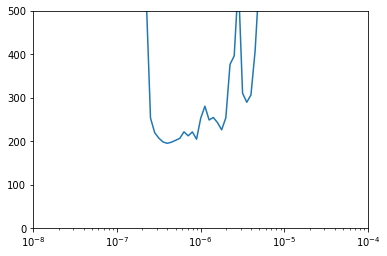

In [10]:
pp.semilogx(history.history["lr"], history.history["loss"])
pp.axis([1e-8, 1e-4, 0, 500])

In [11]:
#-> best learning rate 1e-7
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
   layers.Dense(7, activation="relu", name='dense_1'),
        layers.Dense(5, activation="relu", name='dense_2'),
        layers.Dense(1, name='dense_3'),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train, Y_train, epochs=500)

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 0s 537us/step - loss: 7461.2871 - mae: 7461.7871
Epoch 2/500
13/13 [==============================] - 0s 614us/step - loss: 7372.3911 - mae: 7372.8911
Epoch 3/500
13/13 [==============================] - 0s 614us/step - loss: 7238.6309 - mae: 7239.1309
Epoch 4/500
13/13 [==============================] - 0s 537us/step - loss: 7069.8013 - mae: 7070.3013
Epoch 5/500
13/13 [==============================] - 0s 614us/step - loss: 6861.7368 - mae: 6862.236

13/13 [==============================] - 0s 614us/step - loss: 178.6057 - mae: 179.1023
Epoch 75/500
13/13 [==============================] - 0s 537us/step - loss: 178.6897 - mae: 179.1864
Epoch 76/500
13/13 [==============================] - 0s 537us/step - loss: 179.0485 - mae: 179.5415
Epoch 77/500
13/13 [==============================] - 0s 537us/step - loss: 179.1640 - mae: 179.6583
Epoch 78/500
13/13 [==============================] - 0s 537us/step - loss: 179.2319 - mae: 179.7280
Epoch 79/500
13/13 [==============================] - 0s 614us/step - loss: 182.2336 - mae: 182.7318
Epoch 80/500
13/13 [==============================] - 0s 460us/step - loss: 180.8274 - mae: 181.3257
Epoch 81/500
13/13 [==============================] - 0s 537us/step - loss: 178.5874 - mae: 179.0845
Epoch 82/500
13/13 [==============================] - 0s 460us/step - loss: 178.9718 - mae: 179.4677
Epoch 83/500
13/13 [==============================] - 0s 536us/step - loss: 178.1350 - mae: 178.6321
Epo

13/13 [==============================] - 0s 537us/step - loss: 178.2410 - mae: 178.7398
Epoch 155/500
13/13 [==============================] - 0s 537us/step - loss: 179.8488 - mae: 180.3454
Epoch 156/500
13/13 [==============================] - 0s 537us/step - loss: 177.7466 - mae: 178.2414
Epoch 157/500
13/13 [==============================] - 0s 537us/step - loss: 178.4737 - mae: 178.9667
Epoch 158/500
13/13 [==============================] - 0s 616us/step - loss: 177.6806 - mae: 178.1757
Epoch 159/500
13/13 [==============================] - 0s 537us/step - loss: 178.3598 - mae: 178.8559
Epoch 160/500
13/13 [==============================] - 0s 614us/step - loss: 180.0567 - mae: 180.5552
Epoch 161/500
13/13 [==============================] - 0s 537us/step - loss: 182.8177 - mae: 183.3171
Epoch 162/500
13/13 [==============================] - 0s 614us/step - loss: 185.4659 - mae: 185.9641
Epoch 163/500
13/13 [==============================] - 0s 460us/step - loss: 187.8887 - mae: 188

13/13 [==============================] - 0s 537us/step - loss: 178.6210 - mae: 179.1184
Epoch 235/500
13/13 [==============================] - 0s 537us/step - loss: 178.7749 - mae: 179.2700
Epoch 236/500
13/13 [==============================] - 0s 537us/step - loss: 180.6068 - mae: 181.1043
Epoch 237/500
13/13 [==============================] - 0s 537us/step - loss: 177.3279 - mae: 177.8259
Epoch 238/500
13/13 [==============================] - 0s 614us/step - loss: 184.7108 - mae: 185.2085
Epoch 239/500
13/13 [==============================] - 0s 537us/step - loss: 183.3672 - mae: 183.8652
Epoch 240/500
13/13 [==============================] - 0s 614us/step - loss: 179.9848 - mae: 180.4833
Epoch 241/500
13/13 [==============================] - 0s 537us/step - loss: 180.7508 - mae: 181.2497
Epoch 242/500
13/13 [==============================] - 0s 616us/step - loss: 178.0980 - mae: 178.5945
Epoch 243/500
13/13 [==============================] - 0s 537us/step - loss: 177.9975 - mae: 178

13/13 [==============================] - 0s 537us/step - loss: 179.8134 - mae: 180.3123
Epoch 315/500
13/13 [==============================] - 0s 537us/step - loss: 179.7559 - mae: 180.2539
Epoch 316/500
13/13 [==============================] - 0s 537us/step - loss: 180.6883 - mae: 181.1882
Epoch 317/500
13/13 [==============================] - 0s 537us/step - loss: 177.9218 - mae: 178.4215
Epoch 318/500
13/13 [==============================] - 0s 460us/step - loss: 177.1452 - mae: 177.6428
Epoch 319/500
13/13 [==============================] - 0s 537us/step - loss: 177.6244 - mae: 178.1230
Epoch 320/500
13/13 [==============================] - 0s 537us/step - loss: 178.3888 - mae: 178.8835
Epoch 321/500
13/13 [==============================] - 0s 554us/step - loss: 177.4616 - mae: 177.9537
Epoch 322/500
13/13 [==============================] - 0s 460us/step - loss: 177.3830 - mae: 177.8816
Epoch 323/500
13/13 [==============================] - 0s 615us/step - loss: 177.7911 - mae: 178

13/13 [==============================] - 0s 565us/step - loss: 177.5970 - mae: 178.0946
Epoch 395/500
13/13 [==============================] - 0s 537us/step - loss: 178.8182 - mae: 179.3159
Epoch 396/500
13/13 [==============================] - 0s 614us/step - loss: 178.3216 - mae: 178.8200
Epoch 397/500
13/13 [==============================] - 0s 614us/step - loss: 176.9644 - mae: 177.4613
Epoch 398/500
13/13 [==============================] - 0s 460us/step - loss: 177.2540 - mae: 177.7514
Epoch 399/500
13/13 [==============================] - 0s 536us/step - loss: 176.7817 - mae: 177.2772
Epoch 400/500
13/13 [==============================] - 0s 537us/step - loss: 177.7233 - mae: 178.2200
Epoch 401/500
13/13 [==============================] - 0s 614us/step - loss: 177.3951 - mae: 177.8940
Epoch 402/500
13/13 [==============================] - 0s 460us/step - loss: 177.7008 - mae: 178.1962
Epoch 403/500
13/13 [==============================] - 0s 690us/step - loss: 179.2554 - mae: 179

13/13 [==============================] - 0s 614us/step - loss: 177.7650 - mae: 178.2621
Epoch 475/500
13/13 [==============================] - 0s 537us/step - loss: 177.5474 - mae: 178.0445
Epoch 476/500
13/13 [==============================] - 0s 614us/step - loss: 177.7871 - mae: 178.2839
Epoch 477/500
13/13 [==============================] - 0s 537us/step - loss: 178.0951 - mae: 178.5912
Epoch 478/500
13/13 [==============================] - 0s 537us/step - loss: 178.3733 - mae: 178.8717
Epoch 479/500
13/13 [==============================] - 0s 614us/step - loss: 178.9514 - mae: 179.4500
Epoch 480/500
13/13 [==============================] - 0s 537us/step - loss: 176.6510 - mae: 177.1408
Epoch 481/500
13/13 [==============================] - 0s 537us/step - loss: 176.8784 - mae: 177.3730
Epoch 482/500
13/13 [==============================] - 0s 460us/step - loss: 178.1328 - mae: 178.6293
Epoch 483/500
13/13 [==============================] - 0s 614us/step - loss: 177.0308 - mae: 177

In [12]:
forecast=model.predict(X_test)

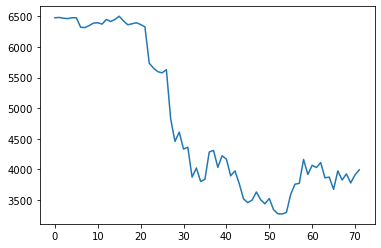

In [13]:
pp.plot(forecast)

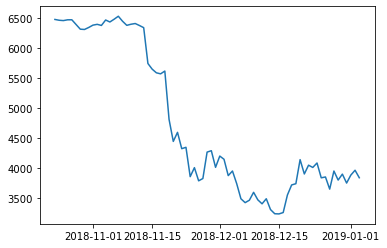

In [14]:
pp.plot(Y_test)

<Figure size 432x288 with 0 Axes>

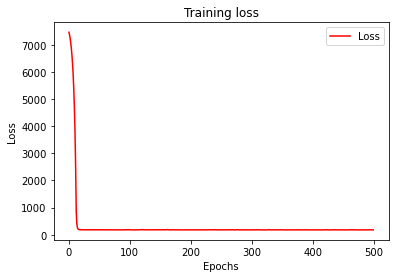

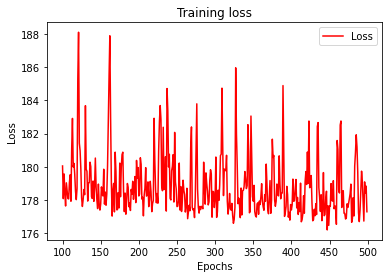

<Figure size 432x288 with 0 Axes>

In [15]:
loss=history.history['loss']
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
epochs=range(len(loss)) # Get number of epochs
pp.plot(epochs, loss, 'r')
pp.title('Training loss')
pp.xlabel("Epochs")
pp.ylabel("Loss")
pp.legend(["Loss"])

pp.figure()


zoomed_loss = loss[100:]
zoomed_epochs = range(100,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
pp.plot(zoomed_epochs, zoomed_loss, 'r')
pp.title('Training loss')
pp.xlabel("Epochs")
pp.ylabel("Loss")
pp.legend(["Loss"])

pp.figure()

In [16]:
#---------------------------Transform in time window ---------------------------------####
## transform data
X_train=""
df_final=df_final.fillna(method='bfill')
X=df_final.copy()
X=X.dropna(axis=0)
number_to_cutoff=int(round(0.15*len(X),0))
Y=X['BTC-USD'].iloc[1:].copy()
Y_test=Y[len(Y)-number_to_cutoff:]
Y_train=Y[:-number_to_cutoff]
X_test=X[len(X)-number_to_cutoff:]
X_train=X[:-number_to_cutoff]
def simple_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis=-1) #why expand one dimension??
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    #ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    #ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
window_size=14
batch_size=10
#shuffle_buffer=1
#X_train=windowed_dataset(df_final, window_size, batch_size, shuffle_buffer)
X_train= tf.data.Dataset.from_tensor_slices(df_final)
X_train=X_train.window(window_size,shift=1, drop_remainder=True)
X_train=X_train.flat_map(lambda v:v.batch(window_size+1))
X_train=X_train.map(lambda w: (w[:-1], w[1:,1]))
X_train=X_train.batch(batch_size)


In [17]:
#ds = ds.window(14+1, 1, drop_remainder=True)
print(X_train)
for x, y in X_train:
#for x in X_train:
    #print("Input:", x.numpy(), " Target:", y.numpy())
    print('Input:', x)
    print('target: ', y)
    #print('Input:', x, 'target: ', y, 'hfdajklés: ', z)
    #for value in x:
       #print('Input:', value) 

<BatchDataset shapes: ((None, None, 7), (None, None)), types: (tf.float64, tf.float64)>
Input: tf.Tensor(
[[[2.43791992e+03 1.33080596e+04 1.13931995e+03 3.34999990e+00
   2.26529999e+02 3.52950012e+02 1.92999995e+00]
  [2.59619995e+03 1.38411904e+04 1.26103003e+03 3.64000010e+00
   2.35350006e+02 3.89399994e+02 2.01999998e+00]
  [2.66489990e+03 1.42431201e+04 1.38502002e+03 3.90000010e+00
   2.57940002e+02 4.16290009e+02 2.00000000e+00]
  [2.53020996e+03 1.36386299e+04 1.35947998e+03 3.72000003e+00
   2.36860001e+02 3.94459991e+02 1.83000004e+00]
  [2.39405005e+03 1.36319805e+04 1.27868994e+03 3.47000003e+00
   2.31889999e+02 4.12820007e+02 1.65999997e+00]
  [1.76160999e+03 1.12824902e+04 1.05026001e+03 2.54999995e+00
   1.83860001e+02 3.13109985e+02 1.14999998e+00]
  [1.74880005e+03 1.11627002e+04 1.02468994e+03 2.70000005e+00
   1.88210007e+02 3.19170013e+02 1.30999994e+00]
  [1.70887000e+03 1.11755195e+04 1.01296997e+03 2.71000004e+00
   1.91029999e+02 3.08459991e+02 1.57000005e+00

   1.18440002e+02 1.65160004e+02 6.09000027e-01]]], shape=(10, 13, 7), dtype=float64)
target:  tf.Tensor(
[[9644.91992188 9377.80957031 9196.12988281 9321.16015625 9032.21972656
  8421.         8486.66992188 8709.45996094 8672.90039062 8480.16015625
  8344.78027344 8071.04003906 8247.91015625]
 [9377.80957031 9196.12988281 9321.16015625 9032.21972656 8421.
  8486.66992188 8709.45996094 8672.90039062 8480.16015625 8344.78027344
  8071.04003906 8247.91015625 8249.24023438]
 [9196.12988281 9321.16015625 9032.21972656 8421.         8486.66992188
  8709.45996094 8672.90039062 8480.16015625 8344.78027344 8071.04003906
  8247.91015625 8249.24023438 8533.        ]
 [9321.16015625 9032.21972656 8421.         8486.66992188 8709.45996094
  8672.90039062 8480.16015625 8344.78027344 8071.04003906 8247.91015625
  8249.24023438 8533.         8419.65039062]
 [9032.21972656 8421.         8486.66992188 8709.45996094 8672.90039062
  8480.16015625 8344.78027344 8071.04003906 8247.91015625 8249.24023438
  

In [41]:
X_train.shape

AttributeError: 'BatchDataset' object has no attribute 'shape'

In [29]:
#---------------------------Try with ML for windowed ---------------------------------####
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float32')
model=keras.Sequential(
    [
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ])
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#model.fit(X_train,Y_train, epochs=100, callbacks=[lr_schedule])
history = model.fit(X_train,  epochs=100, callbacks=[lr_schedule])


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

48/48 [==============================] - 0s 7ms/step - loss: 7531.5322 - mae: 7532.0322 - lr: 1.0000e-06
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 7531.5308 - mae: 7532.0308 - lr: 1.1220e-06
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 7531.5298 - mae: 7532.0298 - lr: 1.2589e-06
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 7531.5269 - mae: 7532.0269 - lr: 1.4125e-06
Epoch 5/100
48/48 [=====================

48/48 [==============================] - 0s 6ms/step - loss: 1483.9426 - mae: 1484.4426 - lr: 0.0014
Epoch 65/100
48/48 [==============================] - 0s 6ms/step - loss: 2439.2749 - mae: 2439.7749 - lr: 0.0016
Epoch 66/100
48/48 [==============================] - 0s 6ms/step - loss: 2590.5115 - mae: 2591.0112 - lr: 0.0018
Epoch 67/100
48/48 [==============================] - 0s 6ms/step - loss: 2959.0359 - mae: 2959.5359 - lr: 0.0020
Epoch 68/100
48/48 [==============================] - 0s 6ms/step - loss: 7006.7744 - mae: 7007.2744 - lr: 0.0022
Epoch 69/100
48/48 [==============================] - 0s 6ms/step - loss: 7319.9839 - mae: 7320.4839 - lr: 0.0025
Epoch 70/100
48/48 [==============================] - 0s 6ms/step - loss: 2753.7742 - mae: 2754.2742 - lr: 0.0028
Epoch 71/100
48/48 [==============================] - 0s 6ms/step - loss: 3604.2349 - mae: 3604.7349 - lr: 0.0032
Epoch 72/100
48/48 [==============================] - 0s 6ms/step - loss: 5096.1929 - mae: 5096.6929 

(1e-05, 0.1, 0.0, 8000.0)

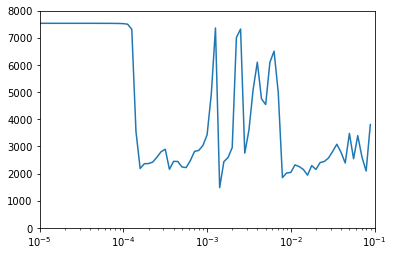

In [31]:
pp.semilogx(history.history["lr"], history.history["loss"])
pp.axis([1e-5, 1e-1, 0, 8000])

In [32]:
#-> best learning rate 3.5481e-03
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=3.5481e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train, epochs=500)

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

48/48 [==============================] - 0s 7ms/step - loss: 7386.8999 - mae: 7387.3999
Epoch 2/500
48/48 [==============================] - 0s 6ms/step - loss: 5983.4702 - mae: 5983.9697
Epoch 3/500
48/48 [==============================] - 0s 6ms/step - loss: 6637.9746 - mae: 6638.4746
Epoch 4/500
48/48 [==============================] - 0s 6ms/step - loss: 7526.7603 - mae: 7527.2603
Epoch 5/500
48/48 [==============================] - 0s 6ms/step - loss: 7523.8921 - mae: 7524.3921
Epoch 6/

48/48 [==============================] - 0s 6ms/step - loss: 1344.4135 - mae: 1344.9135
Epoch 75/500
48/48 [==============================] - 0s 6ms/step - loss: 1344.9648 - mae: 1345.4648
Epoch 76/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.3090 - mae: 1345.8088
Epoch 77/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.3433 - mae: 1345.8433
Epoch 78/500
48/48 [==============================] - 0s 6ms/step - loss: 1344.9257 - mae: 1345.4257
Epoch 79/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.0577 - mae: 1345.5577
Epoch 80/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.1053 - mae: 1345.6053
Epoch 81/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.2521 - mae: 1345.7516
Epoch 82/500
48/48 [==============================] - 0s 6ms/step - loss: 1344.9333 - mae: 1345.4333
Epoch 83/500
48/48 [==============================] - 0s 6ms/step - loss: 1344.8547 - mae: 1345.3550
Epo

48/48 [==============================] - 0s 6ms/step - loss: 1345.8756 - mae: 1346.3750
Epoch 155/500
48/48 [==============================] - 0s 6ms/step - loss: 1347.2694 - mae: 1347.7694
Epoch 156/500
48/48 [==============================] - 0s 6ms/step - loss: 1331.4756 - mae: 1331.9756
Epoch 157/500
48/48 [==============================] - 0s 6ms/step - loss: 1350.3607 - mae: 1350.8606
Epoch 158/500
48/48 [==============================] - 0s 6ms/step - loss: 1332.2947 - mae: 1332.7946
Epoch 159/500
48/48 [==============================] - 0s 6ms/step - loss: 1348.8195 - mae: 1349.3195
Epoch 160/500
48/48 [==============================] - 0s 6ms/step - loss: 1331.0944 - mae: 1331.5936
Epoch 161/500
48/48 [==============================] - 0s 6ms/step - loss: 1439.4299 - mae: 1439.9299
Epoch 162/500
48/48 [==============================] - 0s 6ms/step - loss: 1334.6892 - mae: 1335.1892
Epoch 163/500
48/48 [==============================] - 0s 6ms/step - loss: 1328.8405 - mae: 1329

48/48 [==============================] - 0s 6ms/step - loss: 1434.3181 - mae: 1434.8181
Epoch 235/500
48/48 [==============================] - 0s 6ms/step - loss: 1335.7950 - mae: 1336.2950
Epoch 236/500
48/48 [==============================] - 0s 6ms/step - loss: 1328.3232 - mae: 1328.8232
Epoch 237/500
48/48 [==============================] - 0s 6ms/step - loss: 1346.1112 - mae: 1346.6111
Epoch 238/500
48/48 [==============================] - 0s 6ms/step - loss: 1346.8630 - mae: 1347.3623
Epoch 239/500
48/48 [==============================] - 0s 6ms/step - loss: 1331.9197 - mae: 1332.4197
Epoch 240/500
48/48 [==============================] - 0s 6ms/step - loss: 1347.7886 - mae: 1348.2878
Epoch 241/500
48/48 [==============================] - 0s 6ms/step - loss: 1328.6447 - mae: 1329.1445
Epoch 242/500
48/48 [==============================] - 0s 6ms/step - loss: 1438.8531 - mae: 1439.3530
Epoch 243/500
48/48 [==============================] - 0s 6ms/step - loss: 1334.6696 - mae: 1335

48/48 [==============================] - 0s 6ms/step - loss: 1337.1373 - mae: 1337.6373
Epoch 315/500
48/48 [==============================] - 0s 6ms/step - loss: 1325.4624 - mae: 1325.9622
Epoch 316/500
48/48 [==============================] - 0s 6ms/step - loss: 1346.3053 - mae: 1346.8053
Epoch 317/500
48/48 [==============================] - 0s 6ms/step - loss: 1346.9440 - mae: 1347.4440
Epoch 318/500
48/48 [==============================] - 0s 6ms/step - loss: 1330.7262 - mae: 1331.2264
Epoch 319/500
48/48 [==============================] - 0s 6ms/step - loss: 1349.7245 - mae: 1350.2242
Epoch 320/500
48/48 [==============================] - 0s 6ms/step - loss: 1331.6036 - mae: 1332.1036
Epoch 321/500
48/48 [==============================] - 0s 6ms/step - loss: 1347.5520 - mae: 1348.0520
Epoch 322/500
48/48 [==============================] - 0s 6ms/step - loss: 1332.1382 - mae: 1332.6382
Epoch 323/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.9912 - mae: 1344

48/48 [==============================] - 0s 6ms/step - loss: 1331.7496 - mae: 1332.2496
Epoch 395/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.6038 - mae: 1344.1038
Epoch 396/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.6877 - mae: 1344.1877
Epoch 397/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.8220 - mae: 1344.3220
Epoch 398/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.4041 - mae: 1343.9041
Epoch 399/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.5189 - mae: 1344.0188
Epoch 400/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.5565 - mae: 1344.0565
Epoch 401/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.7388 - mae: 1344.2384
Epoch 402/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.3116 - mae: 1343.8116
Epoch 403/500
48/48 [==============================] - 0s 6ms/step - loss: 1342.9988 - mae: 1343

48/48 [==============================] - 0s 6ms/step - loss: 1343.2502 - mae: 1343.7502
Epoch 475/500
48/48 [==============================] - 0s 6ms/step - loss: 1342.9744 - mae: 1343.4744
Epoch 476/500
48/48 [==============================] - 0s 6ms/step - loss: 1343.9518 - mae: 1344.4518
Epoch 477/500
48/48 [==============================] - 0s 6ms/step - loss: 1344.3928 - mae: 1344.8920
Epoch 478/500
48/48 [==============================] - 0s 6ms/step - loss: 1345.5470 - mae: 1346.0470
Epoch 479/500
48/48 [==============================] - 0s 6ms/step - loss: 1330.0087 - mae: 1330.5087
Epoch 480/500
48/48 [==============================] - 0s 6ms/step - loss: 1348.5574 - mae: 1349.0574
Epoch 481/500
48/48 [==============================] - 0s 6ms/step - loss: 1328.4163 - mae: 1328.9163
Epoch 482/500
48/48 [==============================] - 0s 6ms/step - loss: 1442.5886 - mae: 1443.0886
Epoch 483/500
48/48 [==============================] - 0s 6ms/step - loss: 1255.4974 - mae: 1255

In [20]:
preds_val= model.predict(X_test)
mae=mean_absolute_error(Y_test, preds_val)

ValueError: in user code:

    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 7]


In [21]:
forecast=model.predict(X_test)

ValueError: in user code:

    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 7]


ValueError: x and y must have same first dimension, but have shapes (400,) and (0,)

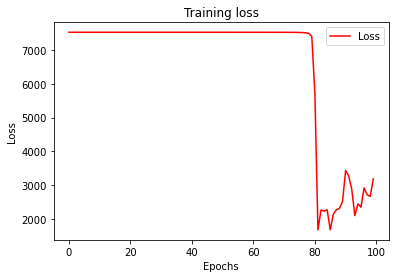

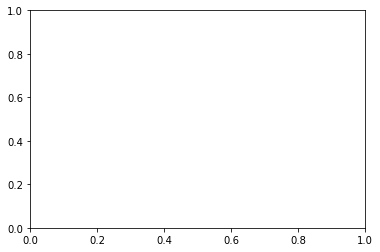

In [22]:
loss=history.history['loss']
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
epochs=range(len(loss)) # Get number of epochs
pp.plot(epochs, loss, 'r')
pp.title('Training loss')
pp.xlabel("Epochs")
pp.ylabel("Loss")
pp.legend(["Loss"])

pp.figure()


zoomed_loss = loss[100:]
zoomed_epochs = range(100,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
pp.plot(zoomed_epochs, zoomed_loss, 'r')
pp.title('Training loss')
pp.xlabel("Epochs")
pp.ylabel("Loss")
pp.legend(["Loss"])

pp.figure()